# AIDI 1003 - 01

Association Rules using Apriori Algorithm

In [1]:
import os 
import pandas as pd
import numpy as np
from apyori import apriori
from collections import Counter
from datetime import datetime
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
aisles = pd.read_csv('aisles.csv')
aisles

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


In [3]:
departments = pd.read_csv('departments.csv')
departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [4]:
products = pd.read_csv('products.csv')
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [5]:
orders = pd.read_csv('orders.csv')
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [6]:
# use only prior orders, so easy to predict based on history

orders = orders[orders.eval_set == 'prior']

orders.drop('eval_set', axis = 1, inplace = True) # drop column

C:\Users\elton\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [7]:
orders.loc[orders.days_since_prior_order.isna()] # users without prior orders

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
11,2168274,2,1,2,11,NaN
26,1374495,3,1,1,14,NaN
39,3343014,4,1,6,11,NaN
45,2717275,5,1,3,12,NaN
...,...,...,...,...,...,...
3420930,969311,206205,1,4,12,NaN
3420934,3189322,206206,1,3,18,NaN
3421002,2166133,206207,1,6,19,NaN
3421019,2227043,206208,1,1,15,NaN


In [8]:
order_products = pd.read_csv('order_products__prior.csv')

order_products

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [9]:
orders_apriori = orders.copy()
orders_user = orders.groupby('user_id')['order_number'].max() #it takes the maximum number of orders placed
orders_user.head()

user_id
1    10
2    14
3    12
4     5
5     4
Name: order_number, dtype: int64

In [10]:
products_user = orders[['order_id', 'user_id']].merge(order_products[['order_id', 'add_to_cart_order']].groupby('order_id').max().rename({'add_to_cart_order': 'order_size'}, axis = 1),on = 'order_id')
products_user

,order_id,user_id,order_size
0,2539329,1,5
1,2398795,1,6
2,473747,1,5
3,2254736,1,5
4,431534,1,8
...,...,...,...
3214869,2558525,206209,3
3214870,2266710,206209,9
3214871,1854736,206209,8
3214872,626363,206209,20


In [11]:
orders_apriori.drop(['user_id', 'order_id'], axis = 1, inplace=True)
orders_apriori.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,2,8,NaN
1,2,3,7,15.0
2,3,3,12,21.0
3,4,4,7,29.0
4,5,4,15,28.0


In [12]:
#Convert to categorical variables since we will work with membership rules:

def order_number_categorical(order_number):
    if order_number in range(3):
        return 'order_number_1-3'
    if order_number in range(3, 5):
        return 'order_number_4-5'
    if order_number in range(5, 10):
        return 'order_number_6-10'
    if order_number in range(10, 20):
        return 'order_number_11-20'
    if order_number in range(20, 40):
        return 'order_number_21-40'
    if order_number in range(40, 60):
        return 'order_number_41-60'
    if order_number >= 60:
        return 'order_number_60+'

In [13]:
orders_apriori.order_number = orders_apriori.order_number.map(order_number_categorical)
orders_apriori.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,order_number_1-3,2,8,NaN
1,order_number_1-3,3,7,15.0
2,order_number_4-5,3,12,21.0
3,order_number_4-5,4,7,29.0
4,order_number_6-10,4,15,28.0


In [14]:
#Total orders per day of the week:

orders_by_dow = orders.order_dow.value_counts()
orders_by_dow

0    557772
1    556705
2    441955
5    425982
6    418848
3    412400
4    401212
Name: order_dow, dtype: int64

In [15]:
#Total products per day of the week:

products_by_dow = orders[['order_id', 'order_dow']].merge(
    order_products[['order_id', 'add_to_cart_order']].groupby('order_id').max().rename({'add_to_cart_order': 'order_size'}, axis = 1),
    on = 'order_id')
products_by_dow = products_by_dow.drop('order_id', axis=1).groupby('order_dow')['order_size'].sum()
products_by_dow

order_dow
0    6209666
1    5665856
2    4217798
3    3844117
4    3787215
5    4209533
6    4500304
Name: order_size, dtype: int64

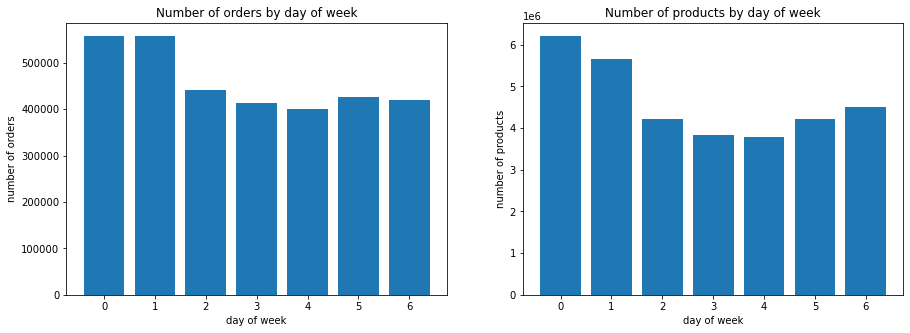

In [16]:
#The results in a more visual way:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(orders_by_dow.index, orders_by_dow)
ax[0].set_title('Number of orders by day of week')
ax[0].set_xlabel('day of week')
ax[0].set_ylabel('number of orders')

ax[1].bar(products_by_dow.index, products_by_dow)
ax[1].set_title('Number of products by day of week')
ax[1].set_xlabel('day of week')
ax[1].set_ylabel('number of products');

In [17]:
def dow_categorical(dow):
    if dow in [0, 1]:
        return 'weekend'
    else:
        return 'weekday'
    
orders_apriori.order_dow = orders_apriori.order_dow.map(dow_categorical)
orders_apriori.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,order_number_1-3,weekday,8,NaN
1,order_number_1-3,weekday,7,15.0
2,order_number_4-5,weekday,12,21.0
3,order_number_4-5,weekday,7,29.0
4,order_number_6-10,weekday,15,28.0


In [18]:
orders_by_hour = orders.order_hour_of_day.value_counts()
orders_by_hour

10    271885
11    268006
15    266132
14    265556
13    261174
12    256206
16    255949
9     243496
17    214080
18    170998
8     168321
19    131620
20     98109
7      86656
21     73436
22     57540
23     37613
6      28792
0      21372
1      11596
5       8972
2       7070
4       5175
3       5120
Name: order_hour_of_day, dtype: int64

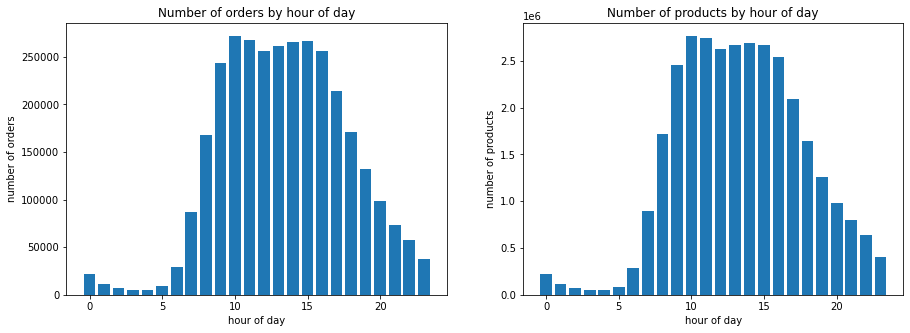

In [19]:
products_by_hour = orders[['order_id', 'order_hour_of_day']].merge(
    order_products[['order_id', 'add_to_cart_order']].groupby('order_id').max().rename({'add_to_cart_order': 'order_size'}, axis = 1),
    on = 'order_id')

products_by_hour = products_by_hour.drop('order_id', axis = 1).groupby('order_hour_of_day')['order_size'].sum()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(orders_by_hour.index, orders_by_hour)
ax[0].set_title('Number of orders by hour of day')
ax[0].set_xlabel('hour of day')
ax[0].set_ylabel('number of orders')

ax[1].bar(products_by_hour.index, products_by_hour)
ax[1].set_title('Number of products by hour of day')
ax[1].set_xlabel('hour of day')
ax[1].set_ylabel('number of products');

In [20]:
# conversion to categorical:

def hour_categorical(hour):
    if hour in range(7):
        return 'early_hours'
    if hour in range(7,10):
        return 'hour_' + str(hour)
    if hour in range(10, 17):
        return 'peak_hours'
    if hour in range(17, 24):
        return 'hour_' + str(hour)

In [21]:
orders_apriori.order_hour_of_day = orders_apriori.order_hour_of_day.map(hour_categorical)
orders_apriori.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,order_number_1-3,weekday,hour_8,NaN
1,order_number_1-3,weekday,hour_7,15.0
2,order_number_4-5,weekday,peak_hours,21.0
3,order_number_4-5,weekday,hour_7,29.0
4,order_number_6-10,weekday,peak_hours,28.0


In [22]:
# conversion to categorical:

def interval_categorical(interval):
    if np.isnan(interval):
        return 'first_order'
    elif interval in [7, 14, 21]:
        return 'interval_weekly'
    elif interval == 30:
        return 'interval_30+'
    else:
        return 'interval_others'
    
orders_apriori.days_since_prior_order = orders_apriori.days_since_prior_order.map(interval_categorical)
orders_apriori.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,order_number_1-3,weekday,hour_8,first_order
1,order_number_1-3,weekday,hour_7,interval_others
2,order_number_4-5,weekday,peak_hours,interval_weekly
3,order_number_4-5,weekday,hour_7,interval_others
4,order_number_6-10,weekday,peak_hours,interval_others


In [23]:
products_id_to_name = {k: v for k, v in zip(products.product_id, products.product_name)}

In [24]:
#create a new data frame:

order_products_names = order_products.copy()
order_products_names['product_name'] = order_products_names.product_id.map(lambda x: products_id_to_name[x])
order_products_names

,order_id,product_id,add_to_cart_order,reordered,product_name
0,2,33120,1,1,Organic Egg Whites
1,2,28985,2,1,Michigan Organic Kale
2,2,9327,3,0,Garlic Powder
3,2,45918,4,1,Coconut Butter
4,2,30035,5,0,Natural Sweetener
...,...,...,...,...,...
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent
32434485,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter
32434486,3421083,4600,8,0,All Natural French Toast Sticks
32434487,3421083,24852,9,1,Banana


In [25]:
#count how many times the product was purchased for the first time and how many times a product was repurchased:

reorder_proportion = pd.crosstab(order_products_names.product_name, order_products_names.reordered)
reorder_proportion

reordered,0,1
product_name,,
#2 Coffee Filters,520,257
#2 Cone White Coffee Filters,10,3
#2 Mechanical Pencils,8,0
#4 Natural Brown Coffee Filters,152,89
& Go! Hazelnut Spread + Pretzel Sticks,77,87
...,...,...
with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,20,17
with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,36,19
with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,37,31


 0 indicates the number of times the product was purchased for the first time and 1 indicates the number of times it was repurchased

In [26]:
reorder_proportion['total'] = reorder_proportion.sum(axis = 1)
reorder_proportion['0.perc'] = reorder_proportion[0] / reorder_proportion['total']
reorder_proportion['1.perc'] = reorder_proportion[1] / reorder_proportion['total']
reorder_proportion.head()

reordered,0,1,total,0.perc,1.perc
product_name,,,,,
#2 Coffee Filters,520,257,777,0.669241,0.330759
#2 Cone White Coffee Filters,10,3,13,0.769231,0.230769
#2 Mechanical Pencils,8,0,8,1.000000,0.000000
#4 Natural Brown Coffee Filters,152,89,241,0.630705,0.369295
& Go! Hazelnut Spread + Pretzel Sticks,77,87,164,0.469512,0.530488


In [27]:
#products that after the first purchase, are always bought again

reorder_proportion.sort_values(by = ['1.perc', 'total'], ascending = False)[['1.perc', 'total']]

reordered,1.perc,total
product_name,,
Raw Veggie Wrappers,0.941176,68
Serenity Ultimate Extrema Overnight Pads,0.931034,87
Orange Energy Shots,0.923077,13
Chocolate Love Bar,0.920792,101
Soy Powder Infant Formula,0.914286,35
...,...,...
Vitality Chicken Breasts with Flaxseed & Vitamins Dog Treats,0.000000,1
Vitamin D Gummies,0.000000,1
Wicked Good No-Fry Wing Marinade,0.000000,1


In [28]:
#Products not ordered:

products_bought = sorted(order_products.product_id.unique())
print(len(products_bought), len(products))

products_not_bought = list(products.product_id[~products.product_id.isin(products_bought)])
products_not_bought

49677 49688


[3630, 3718, 7045, 25383, 27499, 36233, 37703, 43725, 45971, 46625, 49540]

In [29]:
#the name of the products not bought

[products_id_to_name[product] for product in products_not_bought]

['Protein Granola Apple Crisp',
 'Wasabi Cheddar Spreadable Cheese',
 'Unpeeled Apricot Halves in Heavy Syrup',
 'Chocolate Go Bites',
 'Non-Dairy Coconut Seven Layer Bar',
 'Water With Electrolytes',
 'Ultra Sun Blossom Liquid 90 loads Fabric Enhancers',
 'Sweetart Jelly Beans',
 '12 Inch Taper Candle White',
 'Single Barrel Kentucky Straight Bourbon Whiskey',
 'Pure Squeezed  Lemonade']

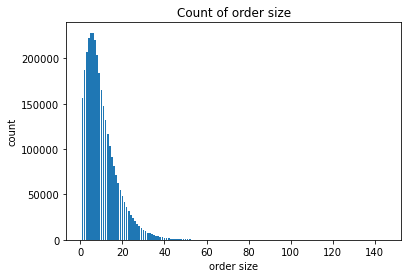

In [30]:
# Market Basket: to do a study on the size of the market basket and how often it happens

cart_size = order_products.groupby('order_id')['add_to_cart_order'].max()
cart_size = cart_size.value_counts()
plt.bar(cart_size.index, cart_size)
plt.title('Count of order size')
plt.xlabel('order size')
plt.ylabel('count');

In [31]:
# Most Frequent Products:

add_to_cart = pd.crosstab(order_products_names.product_name, order_products_names.add_to_cart_order)
add_to_cart

add_to_cart_order,1,2,3,4,5,6,7,8,9,10,...,136,137,138,139,140,141,142,143,144,145
product_name,,,,,,,,,,,,,,,,,,,,,
#2 Coffee Filters,86,61,56,52,38,42,41,50,41,40,...,0,0,0,0,0,0,0,0,0,0
#2 Cone White Coffee Filters,4,0,1,0,2,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
#2 Mechanical Pencils,3,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#4 Natural Brown Coffee Filters,24,15,12,18,16,16,13,9,11,6,...,0,0,0,0,0,0,0,0,0,0
& Go! Hazelnut Spread + Pretzel Sticks,12,7,9,9,12,12,12,9,13,9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,3,5,2,3,5,5,2,2,3,1,...,0,0,0,0,0,0,0,0,0,0
with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,5,5,4,1,6,6,3,1,3,3,...,0,0,0,0,0,0,0,0,0,0
with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,6,4,7,5,7,8,9,6,2,1,...,0,0,0,0,0,0,0,0,0,0


# Association Rules

In [32]:
orders_apriori.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,order_number_1-3,weekday,hour_8,first_order
1,order_number_1-3,weekday,hour_7,interval_others
2,order_number_4-5,weekday,peak_hours,interval_weekly
3,order_number_4-5,weekday,hour_7,interval_others
4,order_number_6-10,weekday,peak_hours,interval_others


In [33]:
# transform dataframe to list

trans = []
for i in range(orders_apriori.shape[0]):
    trans.append([str(orders_apriori.values[i, j]) for j in range(orders_apriori.shape[1])])

In [34]:
# create rules to notice patterns
start = datetime.now()
rules = apriori(trans, min_support = 0.005, min_confidence = 0.2, min_lift = 2)
results = list(rules)
print('Execution time: ', datetime.now() - start)

Execution time:  0:02:02.006807


In [35]:
results[0]

RelationRecord(items=frozenset({'first_order', 'order_number_1-3'}), support=0.06414217166831422, ordered_statistics=[OrderedStatistic(items_base=frozenset({'first_order'}), items_add=frozenset({'order_number_1-3'}), confidence=1.0, lift=7.795183527392111), OrderedStatistic(items_base=frozenset({'order_number_1-3'}), items_add=frozenset({'first_order'}), confidence=0.5, lift=7.795183527392111)])

In [36]:
# transform the rules into a dataframe

A = []
B = []
support = []
confidence = []
lift = []

for result in results:
    s = result[1]
    result_rules = result[2]
    for result_rule in result_rules:
        a = list(result_rule[0])
        b = list(result_rule[1])
        c = result_rule[2]
        l = result_rule[3]
        A.append(a)
        B.append(b)
        support.append(s)
        confidence.append(c)
        lift.append(l) 

rules_df = pd.DataFrame({
    'A': A,
    'B': B,
    'support': support,
    'confidence': confidence,
    'lift': lift
})

rules_df = rules_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)
rules_df

,A,B,support,confidence,lift
0,"[first_order, peak_hours]","[weekend, order_number_1-3]",0.013600,0.367834,8.057873
1,"[weekend, order_number_1-3]","[first_order, peak_hours]",0.013600,0.297930,8.057873
2,"[weekend, first_order]","[peak_hours, order_number_1-3]",0.013600,0.594952,8.047623
3,"[weekend, order_number_1-3]",[first_order],0.022859,0.500763,7.807082
4,[first_order],"[weekend, order_number_1-3]",0.022859,0.356386,7.807082
5,[first_order],"[weekend, peak_hours, order_number_1-3]",0.013600,0.212032,7.799732
6,"[weekend, peak_hours, order_number_1-3]",[first_order],0.013600,0.500292,7.799732
7,"[peak_hours, order_number_1-3]",[first_order],0.036974,0.500126,7.797151
8,[first_order],"[peak_hours, order_number_1-3]",0.036974,0.576435,7.797151
9,[first_order],"[peak_hours, order_number_1-3, weekday]",0.023374,0.364402,7.795650


Association rules are as listed above. for example, consider the 0th rule, we can see relationsip between peak hours, first purchase and occurring on a weekend where purchases are between 1-3. Similarly for rule 37, we can see the relationsip between a weekday order with interval greater than 30 days ordered durng peak hours, and its relationship with being the 4th and 5th purchase

## Association Between Products

In [73]:
# transactions_df = order_products.sort_values('add_to_cart_order', ascending=False)[['order_id','product_id']][:10000]
# transactions_df

transactions_df = order_products[['order_id','product_id']][:10000]
transactions_df

,order_id,product_id
0,2,33120
1,2,28985
2,2,9327
3,2,45918
4,2,30035
...,...,...
9995,1022,21903
9996,1022,38689
9997,1022,30391
9998,1022,18670


Due to memory constraints, we will take only top 10,000 items that are most added to the cart

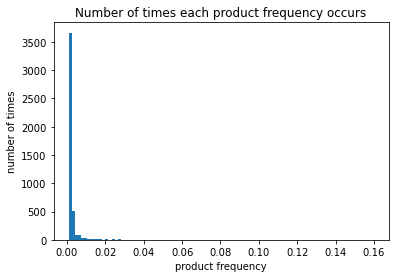

In [74]:
n_orders = len(set(transactions_df.order_id))
n_products = len(set(transactions_df.product_id))

product_frequency = transactions_df.product_id.value_counts() / n_orders
plt.hist(product_frequency, bins = 100)
plt.title('Number of times each product frequency occurs')
plt.xlabel('product frequency')
plt.ylabel('number of times');

min_support = 0.01
products_apriori = product_frequency[product_frequency >= min_support]
#We will now do an analysis to be able to later remove the products that appear few times. 
#We will only search for products that appear at least 4 times, and for that you will need a support of 0.01 


In [75]:
transactions_apriori = transactions_df[transactions_df.product_id.isin(products_apriori.index)]
transactions_apriori

,order_id,product_id
0,2,33120
1,2,28985
5,2,17794
10,3,24838
12,3,21903
...,...,...
9957,1019,24852
9958,1019,24838
9986,1020,41290
9995,1022,21903


In [76]:
order_sizes = transactions_apriori.order_id.value_counts()
order_sizes

1002    17
251     14
431     14
493     14
426     13
        ..
356      1
427      1
777      1
776      1
613      1
Name: order_id, Length: 766, dtype: int64

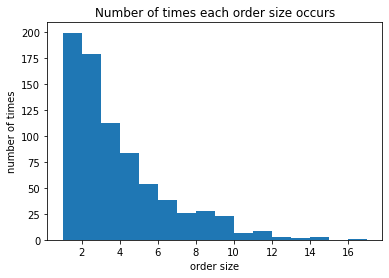

In [77]:
plt.hist(order_sizes, bins = max(order_sizes) - min(order_sizes))
plt.title('Number of times each order size occurs')
plt.xlabel('order size')
plt.ylabel('number of times');

In [78]:
# select orders having atleast two items

min_length = 2
orders_apriori = order_sizes[order_sizes >= min_length]
print(orders_apriori)

1002    17
251     14
431     14
493     14
426     13
        ..
421      2
790      2
792      2
423      2
499      2
Name: order_id, Length: 567, dtype: int64


In [79]:
transactions_apriori = transactions_apriori[transactions_apriori.order_id.isin(orders_apriori.index)]
transactions_apriori

,order_id,product_id
0,2,33120
1,2,28985
5,2,17794
10,3,24838
12,3,21903
...,...,...
9955,1019,43295
9957,1019,24852
9958,1019,24838
9995,1022,21903


In [80]:
#create all possible combinations of products 

transactions_by_order = transactions_apriori.groupby('order_id')['product_id']
for order_id, order_list in transactions_by_order:
    print('Order_id:', order_id, '\nOrder_list: ', list(order_list))
    product_combinations = combinations(order_list, 2)
    print('Product combinations:')
    print([i for i in product_combinations])
    print('\n')

Order_id: 2 
Order_list:  [33120, 28985, 17794]
Product combinations:
[(33120, 28985), (33120, 17794), (28985, 17794)]


Order_id: 3 
Order_list:  [24838, 21903, 46667]
Product combinations:
[(24838, 21903), (24838, 46667), (21903, 46667)]


Order_id: 5 
Order_list:  [13176, 27966, 23909, 47209]
Product combinations:
[(13176, 27966), (13176, 23909), (13176, 47209), (27966, 23909), (27966, 47209), (23909, 47209)]


Order_id: 9 
Order_list:  [21405, 14992, 31506, 432]
Product combinations:
[(21405, 14992), (21405, 31506), (21405, 432), (14992, 31506), (14992, 432), (31506, 432)]


Order_id: 10 
Order_list:  [24852, 31717, 47766, 4605, 21137, 14992, 49235]
Product combinations:
[(24852, 31717), (24852, 47766), (24852, 4605), (24852, 21137), (24852, 14992), (24852, 49235), (31717, 47766), (31717, 4605), (31717, 21137), (31717, 14992), (31717, 49235), (47766, 4605), (47766, 21137), (47766, 14992), (47766, 49235), (4605, 21137), (4605, 14992), (4605, 49235), (21137, 14992), (21137, 49235), (

Order_id: 863 
Order_list:  [1158, 49683]
Product combinations:
[(1158, 49683)]


Order_id: 864 
Order_list:  [13176, 21616]
Product combinations:
[(13176, 21616)]


Order_id: 865 
Order_list:  [22935, 31506, 21137, 45007, 25890, 47626]
Product combinations:
[(22935, 31506), (22935, 21137), (22935, 45007), (22935, 25890), (22935, 47626), (31506, 21137), (31506, 45007), (31506, 25890), (31506, 47626), (21137, 45007), (21137, 25890), (21137, 47626), (45007, 25890), (45007, 47626), (25890, 47626)]


Order_id: 868 
Order_list:  [13176, 21137, 20995, 43352]
Product combinations:
[(13176, 21137), (13176, 20995), (13176, 43352), (21137, 20995), (21137, 43352), (20995, 43352)]


Order_id: 869 
Order_list:  [23375, 25890, 22935, 8193]
Product combinations:
[(23375, 25890), (23375, 22935), (23375, 8193), (25890, 22935), (25890, 8193), (22935, 8193)]


Order_id: 870 
Order_list:  [12341, 21137]
Product combinations:
[(12341, 21137)]


Order_id: 872 
Order_list:  [47209, 33000, 43961, 33548]
Produ

In [81]:
# count all occurances

def product_combinations(transactions_df, max_length = 5):
    transactions_by_order = transactions_df.groupby('order_id')['product_id']
    max_length_reference = max_length
    for order_id, order_list in transactions_by_order:
        max_length = min(max_length_reference, len(order_list))
        order_list = sorted(order_list)
        for l in range(2, max_length + 1):
            product_combinations = combinations(order_list, l)
            for combination in product_combinations:
                yield combination

In [82]:
#how often each of these combinations appears:

combs = product_combinations(transactions_apriori)
counter = Counter(combs).items()
combinations_count = pd.Series([x[1] for x in counter], index = [x[0] for x in counter])
combinations_frequency = combinations_count / n_orders
print(combinations_frequency)

(17794, 28985)                        0.003071
(17794, 33120)                        0.002047
(28985, 33120)                        0.002047
(17794, 28985, 33120)                 0.001024
(21903, 24838)                        0.003071
                                        ...   
(5077, 41950, 43961, 47209)           0.001024
(21903, 41950, 43961, 47209)          0.001024
(5077, 21903, 41950, 43961, 47209)    0.001024
(24838, 43295)                        0.001024
(24838, 24852, 43295)                 0.001024
Length: 60633, dtype: float64


In [83]:
combinations_apriori = combinations_frequency[combinations_frequency >= min_support]
combinations_apriori = combinations_apriori[combinations_apriori.index.map(len) >= min_length]
print(combinations_apriori, len(combinations_apriori))

(13176, 27966)    0.015353
(13176, 47209)    0.023541
(21137, 24852)    0.012282
(24852, 47766)    0.016377
(21903, 24852)    0.024565
(16797, 43352)    0.010235
(24852, 49683)    0.010235
(24852, 47626)    0.011259
(21903, 47209)    0.010235
(21137, 47209)    0.016377
(13176, 22935)    0.011259
(24852, 28204)    0.015353
(24852, 27845)    0.012282
(24852, 45066)    0.011259
(9076, 24852)     0.010235
(16797, 24852)    0.012282
(13176, 21137)    0.019447
dtype: float64 17


In [85]:
# create combinations

A = []
B = []
AB = []
for c in combinations_apriori.index:
    c_length = len(c)
    for l in range(1, c_length):
        comb = combinations(c, l)
        for a in comb:
            AB.append(c)
            b = list(c)
            for e in a:
                b.remove(e)
            b = tuple(b)
            if len(a) == 1:
                a = a[0]
            A.append(a)
            if len(b) == 1:
                b = b[0]
            B.append(b)

In [86]:
apriori_df = pd.DataFrame({'A': A,
                           'B': B,
                           'AB': AB})

apriori_df.head()

,A,B,AB
0,13176,27966,"(13176, 27966)"
1,27966,13176,"(13176, 27966)"
2,13176,47209,"(13176, 47209)"
3,47209,13176,"(13176, 47209)"
4,21137,24852,"(21137, 24852)"


In [87]:
support = {**{k: v for k, v in products_apriori.items()},
           **{k: v for k, v in combinations_frequency.items()}}
support


{24852: 0.15967246673490276,
 13176: 0.1218014329580348,
 21137: 0.07471852610030706,
 21903: 0.07164790174002048,
 47209: 0.06960081883316274,
 47766: 0.05424769703172978,
 16797: 0.05322415557830092,
 47626: 0.04708290685772774,
 22935: 0.04196519959058342,
 27966: 0.03991811668372569,
 24964: 0.03582395087001024,
 26209: 0.033776867963152504,
 39275: 0.032753326509723645,
 27845: 0.03172978505629478,
 28204: 0.02968270214943705,
 45007: 0.02968270214943705,
 45066: 0.028659160696008188,
 5876: 0.027635619242579325,
 30489: 0.027635619242579325,
 49683: 0.027635619242579325,
 42265: 0.027635619242579325,
 30391: 0.02661207778915046,
 43352: 0.02661207778915046,
 17794: 0.0255885363357216,
 19057: 0.0255885363357216,
 19660: 0.02456499488229273,
 26604: 0.02456499488229273,
 46979: 0.02456499488229273,
 44632: 0.02354145342886387,
 21616: 0.02354145342886387,
 40706: 0.02354145342886387,
 9076: 0.022517911975435005,
 37646: 0.022517911975435005,
 33731: 0.022517911975435005,
 44359: 0

In [88]:
#updating the apriori_df with the news combinations:

apriori_df[['support_A', 'support_B', 'support_AB']] = apriori_df[['A', 'B', 'AB']].applymap(lambda x: support[x])
apriori_df

,A,B,AB,support_A,support_B,support_AB
0,13176,27966,"(13176, 27966)",0.121801,0.039918,0.015353
1,27966,13176,"(13176, 27966)",0.039918,0.121801,0.015353
2,13176,47209,"(13176, 47209)",0.121801,0.069601,0.023541
3,47209,13176,"(13176, 47209)",0.069601,0.121801,0.023541
4,21137,24852,"(21137, 24852)",0.074719,0.159672,0.012282
5,24852,21137,"(21137, 24852)",0.159672,0.074719,0.012282
6,24852,47766,"(24852, 47766)",0.159672,0.054248,0.016377
7,47766,24852,"(24852, 47766)",0.054248,0.159672,0.016377
8,21903,24852,"(21903, 24852)",0.071648,0.159672,0.024565
9,24852,21903,"(21903, 24852)",0.159672,0.071648,0.024565


In [89]:
apriori_df.drop('AB', axis = 1, inplace=True)
apriori_df.head()

,A,B,support_A,support_B,support_AB
0,13176,27966,0.121801,0.039918,0.015353
1,27966,13176,0.039918,0.121801,0.015353
2,13176,47209,0.121801,0.069601,0.023541
3,47209,13176,0.069601,0.121801,0.023541
4,21137,24852,0.074719,0.159672,0.012282


In [90]:
#generating confidence and lift:

apriori_df['confidence'] = apriori_df.support_AB / apriori_df.support_A
apriori_df['lift'] = apriori_df.confidence / apriori_df.support_B
apriori_df

,A,B,support_A,support_B,support_AB,confidence,lift
0,13176,27966,0.121801,0.039918,0.015353,0.126050,3.157725
1,27966,13176,0.039918,0.121801,0.015353,0.384615,3.157725
2,13176,47209,0.121801,0.069601,0.023541,0.193277,2.776940
3,47209,13176,0.069601,0.121801,0.023541,0.338235,2.776940
4,21137,24852,0.074719,0.159672,0.012282,0.164384,1.029505
5,24852,21137,0.159672,0.074719,0.012282,0.076923,1.029505
6,24852,47766,0.159672,0.054248,0.016377,0.102564,1.890663
7,47766,24852,0.054248,0.159672,0.016377,0.301887,1.890663
8,21903,24852,0.071648,0.159672,0.024565,0.342857,2.147253
9,24852,21903,0.159672,0.071648,0.024565,0.153846,2.147253


In [93]:
min_confidence = 0.2
min_lift = 1.0
apriori_df = apriori_df[apriori_df.confidence >= min_confidence]
apriori_df = apriori_df[apriori_df.lift >= min_lift]
apriori_df = apriori_df.sort_values(by = 'lift', ascending=False).reset_index(drop = True) #ordering by the lift
apriori_df.head()

,A,B,support_A,support_B,support_AB,confidence,lift
0,43352,16797,0.026612,0.053224,0.010235,0.384615,7.226331
1,28204,24852,0.029683,0.159672,0.015353,0.517241,3.239390
2,27966,13176,0.039918,0.121801,0.015353,0.384615,3.157725
3,21137,47209,0.074719,0.069601,0.016377,0.219178,3.149073
4,47209,21137,0.069601,0.074719,0.016377,0.235294,3.149073


Now it is easy to understand that whoever takes A - 12341 also takes B - 16797, we have the support of each of these A and B instances, and AB support as well as the lift!

In [95]:
#getting the names of the products:

def convert_product_id_to_name(product_ids):
    if type(product_ids) == int:
        return products_id_to_name[product_ids]
    names = []
    for prod in product_ids:
        name = products_id_to_name[prod]
        names.append(name)
    names = tuple(names)
    return names

In [96]:
#applying the names in the data frame:

apriori_df[['A', 'B']] = apriori_df[['A', 'B']].applymap(convert_product_id_to_name)
apriori_df

,A,B,support_A,support_B,support_AB,confidence,lift
0,Raspberries,Strawberries,0.026612,0.053224,0.010235,0.384615,7.226331
1,Organic Fuji Apple,Banana,0.029683,0.159672,0.015353,0.517241,3.239390
2,Organic Raspberries,Bag of Organic Bananas,0.039918,0.121801,0.015353,0.384615,3.157725
3,Organic Strawberries,Organic Hass Avocado,0.074719,0.069601,0.016377,0.219178,3.149073
4,Organic Hass Avocado,Organic Strawberries,0.069601,0.074719,0.016377,0.235294,3.149073
5,Blueberries,Banana,0.022518,0.159672,0.010235,0.454545,2.846737
6,Organic Hass Avocado,Bag of Organic Bananas,0.069601,0.121801,0.023541,0.338235,2.776940
7,Honeycrisp Apple,Banana,0.028659,0.159672,0.011259,0.392857,2.460394
8,Organic Whole Milk,Banana,0.031730,0.159672,0.012282,0.387097,2.424318
9,Cucumber Kirby,Banana,0.027636,0.159672,0.010235,0.370370,2.319563


In [97]:
def association_rules(order_products, min_support, min_length = 2, max_length = 5, 
                      min_confidence = 0.2, min_lift = 1.0):
    
    print('Loading data...')
    transactions_df = order_products[['order_id', 'product_id']]

    print('Calculating product supports...')
    n_orders = len(set(transactions_df.order_id))
    product_frequency = transactions_df.product_id.value_counts()/n_orders
    products_apriori = product_frequency[product_frequency >= min_support]
    transactions_apriori = transactions_df[transactions_df.product_id.isin(products_apriori.index)]
    
    order_sizes = transactions_apriori.order_id.value_counts()
    orders_apriori = order_sizes[order_sizes >= min_length]
    transactions_apriori = transactions_apriori[transactions_apriori.order_id.isin(orders_apriori.index)]
    
    print('Calculating product combinations and supports...')
    
    def product_combinations(transactions_df, max_length = max_length):
        transactions_by_order = transactions_df.groupby('order_id')['product_id']
        max_length_reference = max_length
        for order_id, order_list in transactions_by_order:
            max_length = min(max_length_reference, len(order_list))
            order_list = sorted(order_list)
            for l in range(2, max_length + 1):
                product_combinations = combinations(order_list, l)
                for combination in product_combinations:
                    yield combination
   
    combs = product_combinations(transactions_apriori)
    counter = Counter(combs).items()
    combinations_count = pd.Series([x[1] for x in counter], index = [x[0] for x in counter])
    combinations_frequency = combinations_count/n_orders
    combinations_apriori = combinations_frequency[combinations_frequency >= min_support]
    combinations_apriori = combinations_apriori[combinations_apriori.index.map(len) >= min_length]
    
    print('Populating dataframe...')
    A = []
    B = []
    AB = []
    for c in combinations_apriori.index:
        c_length = len(c)
        for l in range(1, c_length):
            comb = combinations(c, l)
            for a in comb:
                AB.append(c)
                b = list(c)
                for e in a:
                    b.remove(e)
                b = tuple(b)
                if len(a) == 1:
                    a = a[0]
                A.append(a)
                if len(b) == 1:
                    b = b[0]
                B.append(b)
            
    apriori_df = pd.DataFrame({'A': A,
                               'B': B,
                               'AB': AB})
    support = {**{k: v for k, v in products_apriori.items()}, 
               **{k: v for k, v in combinations_frequency.items()}}
    apriori_df[['support_A', 'support_B', 'support_AB']] = apriori_df[['A', 'B', 'AB']].applymap(lambda x: support[x])
    apriori_df.drop('AB', axis = 1, inplace = True)
    apriori_df['confidence'] = apriori_df.support_AB/apriori_df.support_A
    apriori_df['lift'] = apriori_df.confidence / apriori_df.support_B
    apriori_df = apriori_df[apriori_df.confidence >= min_confidence]
    apriori_df = apriori_df[apriori_df.lift >= min_lift]
    apriori_df = apriori_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)
    
    def convert_product_id_to_name(product_ids):
        if type(product_ids) == int:
            return products_id_to_name[product_ids]
        names = []
        for prod in product_ids:
            name = products_id_to_name[prod]
            names.append(name)
        names = tuple(names)
        return names
    
    apriori_df[['A', 'B']] = apriori_df[['A', 'B']].applymap(convert_product_id_to_name)

    print('{} rules were generated'.format(len(apriori_df)))

    return apriori_df

In [98]:
start = datetime.now()
rules = association_rules(order_products, min_support = 0.01)
print('Execution time: ', datetime.now() - start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
11 rules were generated
Execution time:  0:03:00.687399


In [99]:
rules

,A,B,support_A,support_B,support_AB,confidence,lift
0,Organic Raspberries,Organic Strawberries,0.042632,0.082331,0.010533,0.247072,3.000973
1,Organic Fuji Apple,Banana,0.027880,0.146993,0.010558,0.378693,2.576259
2,Organic Raspberries,Bag of Organic Bananas,0.042632,0.118030,0.012599,0.295519,2.503775
3,Organic Hass Avocado,Bag of Organic Bananas,0.066436,0.118030,0.019391,0.291880,2.472945
4,Organic Avocado,Banana,0.054999,0.146993,0.016609,0.301982,2.054395
5,Organic Strawberries,Bag of Organic Bananas,0.082331,0.118030,0.019170,0.232837,1.972702
6,Strawberries,Banana,0.044466,0.146993,0.012825,0.288434,1.962229
7,Large Lemon,Banana,0.047485,0.146993,0.012716,0.267790,1.821783
8,Organic Baby Spinach,Bag of Organic Bananas,0.075251,0.118030,0.015668,0.208217,1.764107
9,Organic Baby Spinach,Banana,0.075251,0.146993,0.015987,0.212445,1.445272


In [ ]:
# rules for organic items

In [100]:
tart = datetime.now()
rules = association_rules(order_products, min_support = 0.002, max_length=3)
print('Execution time: ', datetime.now() - start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
211 rules were generated
Execution time:  0:13:13.778093


Here the lift and the confidence already show higher values. If we analyze the first 7 rules we see that the proportion of one occurring, and the other also occurring is very high, showing a preferable relationship between such products. Rules 11 to 14 show a taste for flavored waters. It shows the habit of occurrence among the products, where one is taken, the chances of taking the other is high. Showing that possibly consumers take more than one flavored water, this explains the high chances of being taken one if the other is also taken.

In [101]:
rules

,A,B,support_A,support_B,support_AB,confidence,lift
0,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,0.005990,0.005094,0.002247,0.375136,73.640837
1,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005094,0.005990,0.002247,0.441106,73.640837
2,Vanilla Skyr Nonfat Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005643,0.005990,0.002069,0.366718,61.222024
3,Icelandic Style Skyr Blueberry Non-fat Yogurt,Vanilla Skyr Nonfat Yogurt,0.005990,0.005643,0.002069,0.345485,61.222024
4,Total 2% with Strawberry Lowfat Greek Strained...,Total 2% Lowfat Greek Strained Yogurt With Blu...,0.009298,0.006457,0.002902,0.312147,48.343394
...,...,...,...,...,...,...,...
206,Apple Honeycrisp Organic,Banana,0.026446,0.146993,0.005422,0.205034,1.394853
207,Sparkling Lemon Water,Banana,0.010199,0.146993,0.002088,0.204740,1.392849
208,Grated Parmesan,Banana,0.014071,0.146993,0.002873,0.204165,1.388938
209,Organic Granny Smith Apple,Banana,0.018283,0.146993,0.003702,0.202504,1.377643
